# A notebook to evaluate terrain masked WOfS

### Load packages

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import datacube
from datacube.utils import masking

import sys
sys.path.append('../Scripts')
from deafrica_datahandling import wofs_fuser, mostcommon_crs, load_ard
from deafrica_plotting import rgb

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='terrain_masked_wofs')

In [5]:
product = 'ga_ls8c_wofs_2_terrain'
#product = 'ga_ls8c_wofs_2'

### Analysis parameters


In [6]:

# Cape Town, South Africa
lat = -33.6
lon = 19.5
buffer = 0.15

# Lesotho
#lat = -29.5
#lon = 28.1
#buffer = 0.15

# Ghana
#lat = 6.95
#lon = -1.95
#buffer = 0.05
#lat, lon = -4.9, 39.2
#buffer = 0.125

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)


query1 = {
    'x': lon_range,
    'y': lat_range,
    "time": ("2018-01-01", "2018-02-01"),
}

query2 = {
    'x': lon_range,
    'y': lat_range,
    "time": ("2018-07-01", "2018-08-01"),
}


In [8]:
# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product=product, query=query1)


Using pixel quality parameters for USGS Collection 2
Finding datasets
    usgs_ls8c_level2_2
Counting good quality pixels for each time step
Filtering to 2 out of 4 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 2 time steps
Using pixel quality parameters for USGS Collection 2
Finding datasets
    usgs_ls8c_level2_2
Counting good quality pixels for each time step
Filtering to 2 out of 4 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 2 time steps


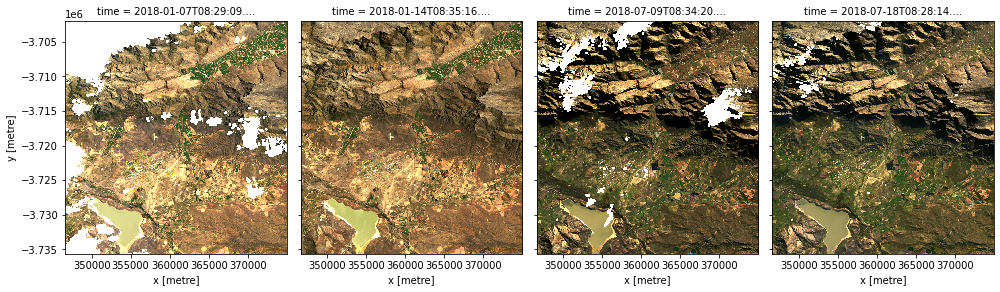

In [34]:
bands = ["red", "green", "blue"]

ds1 = load_ard(dc=dc,
              products=["usgs_ls8c_level2_2"],
              measurements=bands, min_gooddata=0.5,
              output_crs=output_crs,
              resolution=(-30,30), group_by='solar_day', 
              **query1)

ds2 = load_ard(dc=dc,
              products=["usgs_ls8c_level2_2"],
              measurements=bands, min_gooddata=0.9,
              output_crs=output_crs,
              resolution=(-30,30), group_by='solar_day', 
              **query2)

ds = xr.concat([ds1,ds2], dim='time')
ds.to_array().plot.imshow(col='time', robust=True, figsize=(14, 14.*len(ds.y)/len(ds.x)/len(ds.time)));

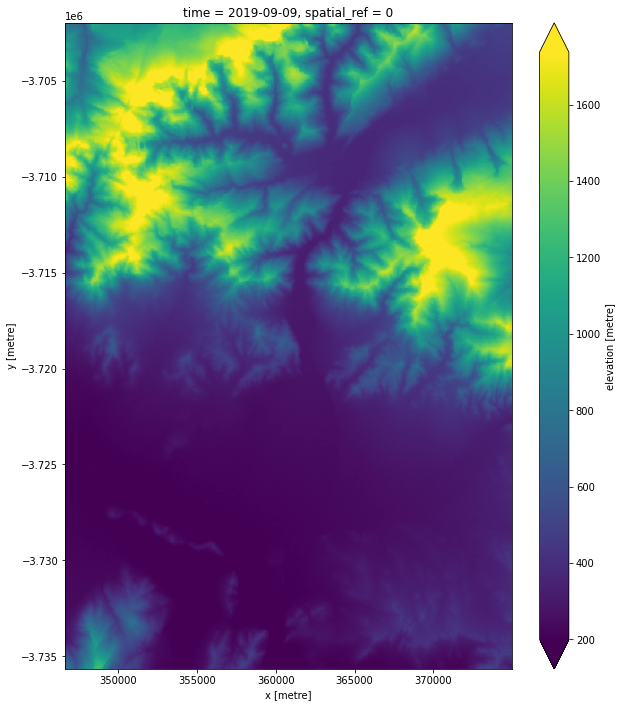

In [35]:
srtm = dc.load(product='srtm', output_crs=output_crs, resolution=(-30,30), x=lon_range, y=lat_range).squeeze()
srtm.elevation.plot(robust=True, figsize=(10, 10.*len(srtm.y)/len(srtm.x)));

In [36]:
wofls1 = dc.load(product=product, output_crs=output_crs, resolution=(-30,30), group_by='solar_day', fuse_func=wofs_fuser, **query1).sel(time=ds1.time)
wofls2 = dc.load(product=product, output_crs=output_crs, resolution=(-30,30), group_by='solar_day', fuse_func=wofs_fuser, **query2).sel(time=ds2.time)
wofls = xr.concat([wofls1,wofls2], dim='time')

In [38]:
wofls.affine

Affine(30.0, 0.0, 346620.0,
       0.0, -30.0, -3701970.0)

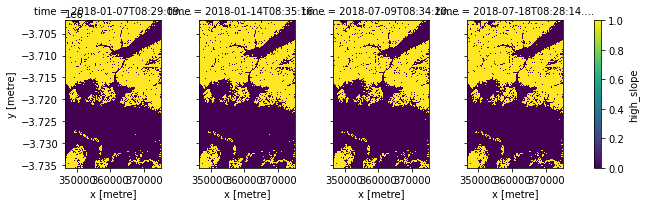

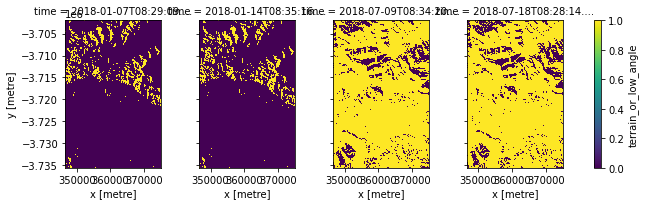

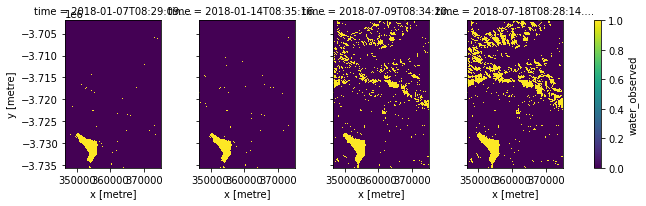

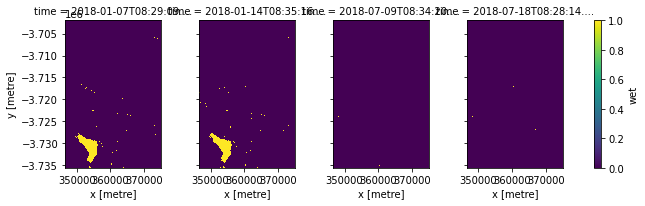

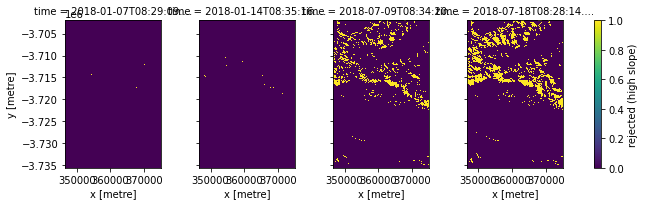

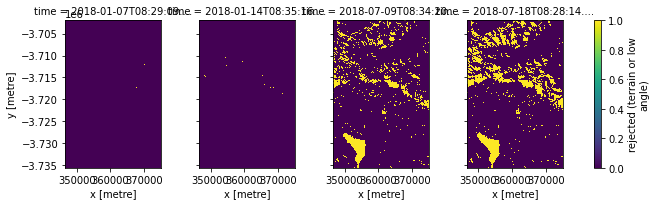

In [9]:
for key in ['high_slope','terrain_or_low_angle', 'water_observed', 'wet']: #wofls.water.attrs['flags_definition'].keys():
    masked = masking.make_mask(wofls, **{key:True}).rename({'water':key})
    if len(masked.time)==1: 
        masked[key].isel(time=0).plot(vmin=0, vmax=1, figsize=(10, 10.*len(masked.y)/len(masked.x)));
        plt.show();
    else:masked[key].plot(col='time',vmin=0, vmax=1, figsize=(10, 10.*len(masked.y)/len(masked.x)/len(masked.time)));

key = 'rejected (high slope)'
#masked = masking.make_mask(wofls, water_observed=True).where(~masking.make_mask(wofls, wet=True)).rename({'water':key})
masked = masking.make_mask(wofls, water_observed=True, high_slope=True).rename({'water':key})
if len(masked.time)==1: 
    masked[key].isel(time=0).plot(vmin=0, vmax=1, figsize=(10, 10.*len(masked.y)/len(masked.x)));
    plt.show();
else:masked[key].plot(col='time',vmin=0, vmax=1, figsize=(10, 10.*len(masked.y)/len(masked.x)/len(masked.time)));

key = 'rejected (terrain or low angle)'
#masked = masking.make_mask(wofls, water_observed=True).where(~masking.make_mask(wofls, wet=True)).rename({'water':key})
masked = masking.make_mask(wofls, water_observed=True, terrain_or_low_angle=True).rename({'water':key})
if len(masked.time)==1: 
    masked[key].isel(time=0).plot(vmin=0, vmax=1, figsize=(10, 10.*len(masked.y)/len(masked.x)));
    plt.show();
else:masked[key].plot(col='time',vmin=0, vmax=1, figsize=(10, 10.*len(masked.y)/len(masked.x)/len(masked.time)));

plt.savefig('test.png')

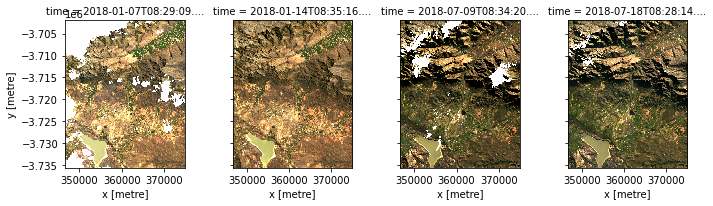

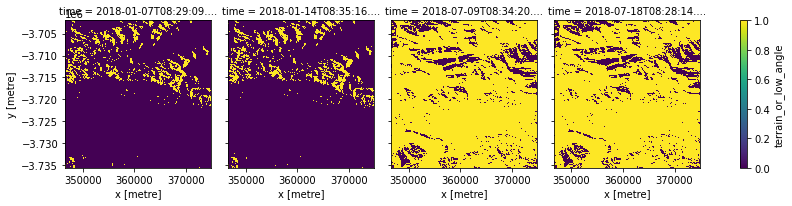

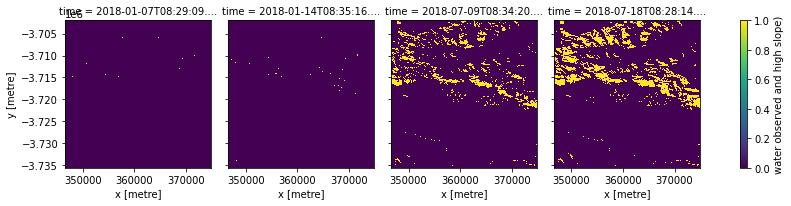

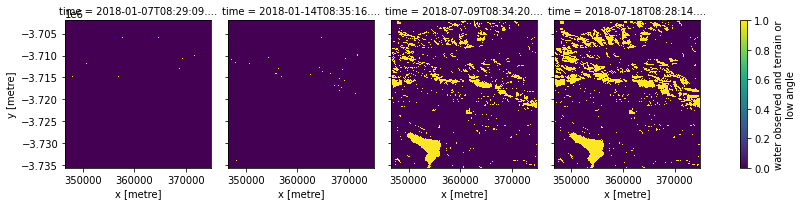

In [10]:
ds.to_array().plot.imshow(col='time', robust=True, figsize=(10, 10.*len(ds.y)/len(ds.x)/len(ds.time)));

for key in ['terrain_or_low_angle']: #wofls.water.attrs['flags_definition'].keys():
    masked = masking.make_mask(wofls, **{key:True}).rename({'water':key})
    if len(masked.time)==1: 
        masked[key].isel(time=0).plot(vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)));
        plt.show();
    else:masked[key].plot(col='time',vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)/len(masked.time)));

key = 'water observed and high slope)'
#masked = masking.make_mask(wofls, water_observed=True).where(~masking.make_mask(wofls, wet=True)).rename({'water':key})
masked = masking.make_mask(wofls, water_observed=True, high_slope=True).rename({'water':key})
if len(masked.time)==1: 
    masked[key].isel(time=0).plot(vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)));
    plt.show();
else:masked[key].plot(col='time',vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)/len(masked.time)));

key = 'water observed and terrain or low angle'
#masked = masking.make_mask(wofls, water_observed=True).where(~masking.make_mask(wofls, wet=True)).rename({'water':key})
masked = masking.make_mask(wofls, water_observed=True, terrain_or_low_angle=True).rename({'water':key})
if len(masked.time)==1: 
    masked[key].isel(time=0).plot(vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)));
    plt.show();
else:masked[key].plot(col='time',vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)/len(masked.time)));


## Annual summay with all maskings

In [11]:
query = {
    'x': lon_range,
    'y': lat_range,
    "time": ("2018-01-01", "2018-12-31"),
}

wofls = dc.load(product=product, output_crs=output_crs, resolution=(-30,30), group_by='solar_day', fuse_func=wofs_fuser, **query)

In [12]:
matching_datasets = dc.find_datasets(product = product, **query)
crs_list = [str(i.crs) for i in matching_datasets]
set(crs_list)

{'epsg:32634'}

In [13]:
wet = masking.make_mask(wofls, wet=True)
dry = masking.make_mask(wofls, dry=True)

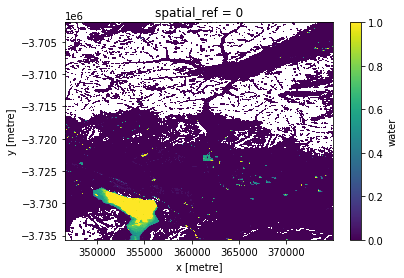

In [14]:
summary = wet.water.sum(dim='time')/(wet.water.sum(dim='time')+dry.water.sum(dim='time'))
summary.plot();

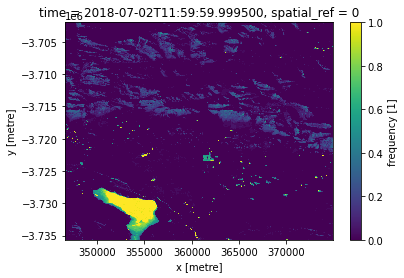

In [15]:
current = dc.load(product = 'ga_ls8c_wofs_2_annual_summary',output_crs=output_crs, resolution=(-30,30), measurements=['frequency'], **query).squeeze().frequency
current.plot();

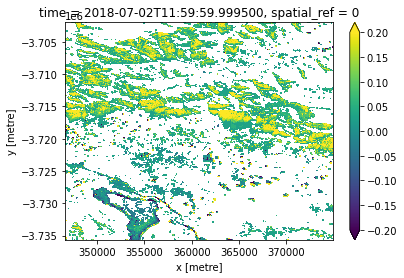

In [16]:
diff =(current-summary.where(~np.isnan(summary),0))
diff.where(diff!=0).plot(vmin=-0.2, vmax=0.2);

## Annual summay with slope masking

In [17]:
cloud = masking.make_mask(wofls, cloud=True)
shadow = masking.make_mask(wofls, cloud_shadow=True)
nodata = masking.make_mask(wofls, nodata=True)
high_slope = masking.make_mask(wofls, high_slope=True)
noncontig = masking.make_mask(wofls, noncontiguous=True)
terrain_shadow = masking.make_mask(wofls, terrain_or_low_angle=True)

bad = (cloud | shadow | nodata | high_slope | noncontig)
clear = ~bad

In [18]:
wet2 = clear & masking.make_mask(wofls, water_observed=True)
dry2 = clear & masking.make_mask(wofls, water_observed=False)

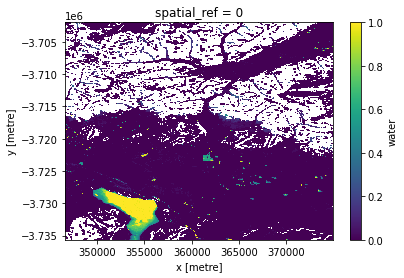

In [19]:
summary2 = wet2.water.sum(dim='time')/(wet2.water.sum(dim='time')+dry2.water.sum(dim='time'))
summary2.plot();

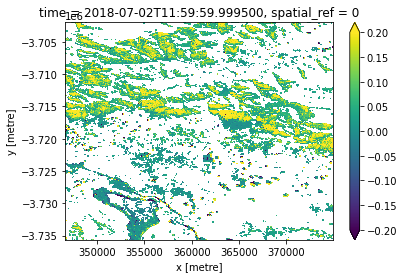

In [20]:
diff2 =(current-summary2.where(~np.isnan(summary2),0))
diff2.where(diff!=0).plot(vmin=-0.2, vmax=0.2);

## Banding in slope

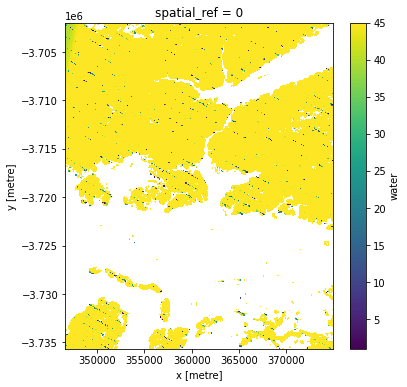

In [21]:
sloped= high_slope.water.sum(dim='time')
sloped.where(sloped!=0).plot(figsize=(6,6));

# not sure how to fix

## Slopw, Terrain shadow, SIA thresholds

In [84]:
from terrain import shadows_and_slope
from terrain import *
import scipy.ndimage

def dilate(array):
    """Dilation e.g. for cloud and cloud/terrain shadow"""
    # kernel = [[1] * 7] * 7 # blocky 3-pixel dilation
    y, x = np.ogrid[-3:4, -3:4]
    kernel = ((x * x) + (y * y) <= 3.5**2)  # disk-like 3-pixel radial dilation
    return scipy.ndimage.binary_dilation(array, structure=kernel)


In [85]:
# Current code uses 'average' resampling

dsm = None
resampling='bilinear'
dsm = dc.load(product='srtm',x= lon_range, y=lat_range, output_crs=output_crs, resolution=(-30,30), resampling=resampling).squeeze()

In [86]:
shadows_array = np.zeros_like(wofls.water.values)
slope_array = np.zeros_like(wofls.water.values)
sia_array =  np.zeros_like(wofls.water.values)

In [87]:
# wrong pixel size but dilate?
# currently uses 25 m pixel, resulting in more terrain shadow masked, so OK....

for idx in range(len(wofls.time)):
    shadows, slope, sia = shadows_and_slope(dsm, wofls.water.time.values[idx], pixel_scale_m=30.0)
    shadows_array[idx,:,:] = shadows 
    slope_array[idx,:,:] = slope
    sia_array[idx,:,:] = sia

lat/lon for sia: -33.60000035122492 19.499664387123577
lat/lon for sia: -33.60000035122492 19.499664387123577
lat/lon for sia: -33.60000035122492 19.499664387123577
lat/lon for sia: -33.60000035122492 19.499664387123577


In [88]:
wofls['shadows'] = ('time','y','x'), shadows_array
wofls['slope'] = ('time','y','x'), slope_array
wofls['sia'] = ('time','y','x'), sia_array

In [27]:
some_wofls = wofls.sel(time=ds.time)


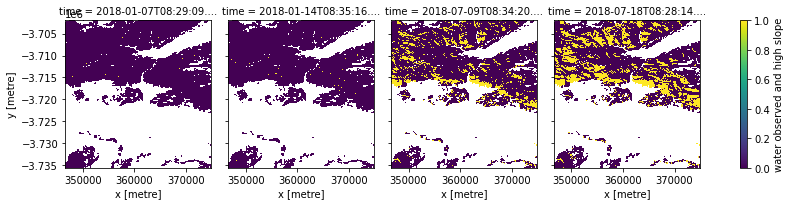

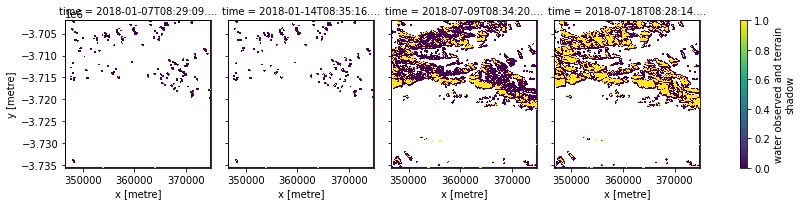

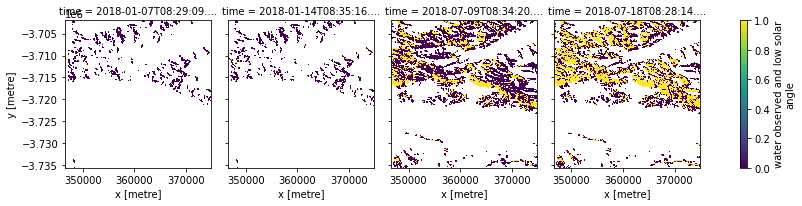

In [28]:
key = 'water observed and high slope'
masked = masking.make_mask(some_wofls, water_observed=True).where(some_wofls.slope>20.).rename({'water':key})
if len(masked.time)==1: 
    masked[key].isel(time=0).plot(vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)));
    plt.show();
else:masked[key].plot(col='time',vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)/len(masked.time)));

key = 'water observed and terrain shadow'
masked = masking.make_mask(some_wofls, water_observed=True).where(some_wofls.shadows!=255).rename({'water':key})
if len(masked.time)==1: 
    masked[key].isel(time=0).plot(vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)));
    plt.show();
else:masked[key].plot(col='time',vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)/len(masked.time)));

key = 'water observed and low solar angle'
masked = masking.make_mask(some_wofls, water_observed=True).where(some_wofls.sia<10).rename({'water':key})
if len(masked.time)==1: 
    masked[key].isel(time=0).plot(vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)));
    plt.show();
else:masked[key].plot(col='time',vmin=0, vmax=1, figsize=(12.2, 10.*len(masked.y)/len(masked.x)/len(masked.time)));
